<a href="https://colab.research.google.com/github/garylau1/Generative_model/blob/main/Generative_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic:GAN for generating cars

## Introduction:
Generative Adversarial Networks (GANs) have emerged as a powerful tool in deep learning for generating high-quality synthetic data. In this project, I aim to train a GAN model using PyTorch to generate realistic images of cars. This endeavor combines advanced neural network techniques with the flexibility of PyTorch to produce a model capable of synthesizing diverse car images.

The dataset used for this project is sourced from Kaggle's Cars Image Dataset. It consists of 4,165 JPG images spanning seven distinct car categories. The dataset is organized into two folders, train and test, each containing subfolders representing the various car classes. This structure provides an ideal foundation for training a GAN by offering a rich variety of car types and visual features.

The primary goal of this project is to develop a GAN that can learn the underlying data distribution of the car images and generate new, high-quality car images that are visually similar to the dataset examples. This report outlines the steps involved in preprocessing the dataset, designing and training the GAN, and evaluating its performance in generating realistic car images.

In [4]:
import torch
import torch.nn as nn

import torchvision
import numpy
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

Unzipping the Car_Image.zip file to extract its contents into the current working directory:

In [5]:
!unzip /content/Car_Image.zip

Archive:  /content/Car_Image.zip
  inflating: Cars Dataset/test/Audi/1000.jpg  
  inflating: Cars Dataset/test/Audi/1003.jpg  
  inflating: Cars Dataset/test/Audi/1008.jpg  
  inflating: Cars Dataset/test/Audi/1020.jpg  
  inflating: Cars Dataset/test/Audi/1022.jpg  
  inflating: Cars Dataset/test/Audi/1025.jpg  
  inflating: Cars Dataset/test/Audi/1027.jpg  
  inflating: Cars Dataset/test/Audi/1038.jpg  
  inflating: Cars Dataset/test/Audi/104.jpg  
  inflating: Cars Dataset/test/Audi/1043.jpg  
  inflating: Cars Dataset/test/Audi/1051.jpg  
  inflating: Cars Dataset/test/Audi/1059.jpg  
  inflating: Cars Dataset/test/Audi/1060.jpg  
  inflating: Cars Dataset/test/Audi/1064.jpg  
  inflating: Cars Dataset/test/Audi/1066.jpg  
  inflating: Cars Dataset/test/Audi/1072.jpg  
  inflating: Cars Dataset/test/Audi/1073.jpg  
  inflating: Cars Dataset/test/Audi/1080.jpg  
  inflating: Cars Dataset/test/Audi/1084.jpg  
  inflating: Cars Dataset/test/Audi/1085.jpg  
  inflating: Cars Dataset/te

## Data-Preprocessing:

To effectively train the Generative Adversarial Network (GAN), it is crucial to organize and preprocess the dataset into a form suitable for deep learning models. This section focuses on loading the car image dataset using PyTorch's torchvision.datasets.ImageFolder class and applying preprocessing transformations to standardize the data for input to the model. The dataset is then wrapped into PyTorch DataLoader objects to facilitate efficient batch-wise data loading during training and testing. These steps ensure that the images are correctly formatted and accessible in a manner conducive to high-performance model training.

In [6]:

from torch.utils.data import DataLoader



# Loading the training dataset from the specified directory and applying transformations:
# - ToTensor: Converts the image to a PyTorch tensor and normalizes pixel values to [0, 1].
# - Resize: Resizes all images to a uniform size of 64x64 pixels.
trainset = torchvision.datasets.ImageFolder(
    root="/content/Cars Dataset/train",
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64))
    ])
)

# Loading the testing dataset from the specified directory with the same transformations.
testset = torchvision.datasets.ImageFolder(
    root="/content/Cars Dataset/test",
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64))
    ])
)

# Importing the DataLoader class from PyTorch for handling dataset batches.
from torch.utils.data import DataLoader

# Creating a DataLoader for the training dataset:
# - batch_size=32: Divides the dataset into mini-batches of 32 images.
# - shuffle=True: Randomly shuffles the dataset at the start of each epoch for better training.
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Creating a DataLoader for the testing dataset:
# - batch_size=32: Divides the dataset into mini-batches of 32 images.
# - shuffle=False: Keeps the dataset order intact for evaluation purposes.
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

## Generator:

The generator in a Generative Adversarial Network (GAN) is a neural network designed to create synthetic data that mimics the real dataset. In this section, a key building block of the generator, the GenBlock class, is defined. This block consists of a linear layer followed by a ReLU activation function, which enables the model to learn complex data representations. By modularizing the architecture, the generator becomes flexible and easier to construct, maintain, and expand for specific tasks such as generating realistic car images.

In [17]:


# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining a generator block as a modular component of the generator network
class GenBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        """
        Initializes the GenBlock module with a linear layer and ReLU activation.

        Args:
            in_feature (int): The number of input features to the linear layer.
            out_feature (int): The number of output features from the linear layer.
        """
        super().__init__()  # Initialize the parent class
        # Define a sequential block with:
        # - A linear layer to transform input to the desired output size.
        # - A ReLU activation function to introduce non-linearity.
        self.main = nn.Sequential(
            nn.Linear(in_feature, out_feature),  # Fully connected layer
            nn.ReLU(inplace=True)  # ReLU activation to add non-linearity
        )

    def forward(self, x):
        """
        Forward pass of the generator block.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after applying the linear transformation and ReLU activation.
        """
        return self.main(x)  # Pass the input through the defined block



 The Generator class defines the overall architecture of the generator network, built as a series of GenBlock layers followed by a final linear layer and a Tanh activation function. This design enables the generator to transform random noise into high-dimensional image data. The final output is reshaped into the format of RGB images with dimensions
3
×
64
×
64
3×64×64, making it compatible with the car image dataset used in this project.

In [18]:
# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining the Generator class, which builds the full generator network
class Generator(nn.Module):
    def __init__(self):
        """
        Initializes the Generator network, which consists of multiple GenBlocks,
        a final linear layer, and a Tanh activation function.

        The generator transforms a random noise vector (latent space) into a
        realistic RGB image with dimensions 3x64x64.

        Architecture:
        - GenBlock(100, 256): Expands latent vector to 256 features.
        - GenBlock(256, 512): Further expands to 512 features.
        - GenBlock(512, 1024): Further expands to 1024 features.
        - Linear(1024, 3*64*64): Maps features to a flattened image representation.
        - Tanh(): Normalizes pixel values to the range [-1, 1].
        """
        super().__init__()  # Initialize the parent class
        # Define the generator network as a sequence of layers
        self.main = nn.Sequential(
            GenBlock(100, 256),    # First block: Latent space to 256 features
            GenBlock(256, 512),   # Second block: 256 to 512 features
            GenBlock(512, 1024),  # Third block: 512 to 1024 features
            nn.Linear(1024, 3 * 64 * 64),  # Fully connected layer for image output
            nn.Tanh()  # Tanh activation for output normalization
        )

    def forward(self, x):
        """
        Forward pass of the Generator network.

        Args:
            x (Tensor): Input tensor representing random noise (latent space).

        Returns:
            Tensor: Output tensor reshaped into RGB image format (batch_size, 3, 64, 64).
        """
        # Pass the input through the defined generator network
        return self.main(x).view(-1, 3, 64, 64)  # Reshape the output to image dimensions


## Discriminator:

The discriminator in a Generative Adversarial Network (GAN) serves as a classifier, distinguishing between real images from the dataset and synthetic images generated by the generator. To build the discriminator network, the DisBlock class is introduced as a reusable building block. Each block consists of a linear layer for feature transformation, a LeakyReLU activation function to prevent the dying ReLU problem by allowing small gradients for negative inputs, and a dropout layer to improve generalization by preventing overfitting. This modular design ensures the discriminator is effective in learning features that differentiate between real and fake images.

In [19]:
# Importing the necessary library for defining neural network modules
import torch.nn as nn

# Defining a discriminator block as a modular component of the discriminator network
class DisBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        """
        Initializes the DisBlock module with a linear layer, LeakyReLU activation,
        and a dropout layer for regularization.

        Args:
            in_feature (int): The number of input features to the linear layer.
            out_feature (int): The number of output features from the linear layer.
        """
        super().__init__()  # Initialize the parent class
        # Define a sequential block with:
        # - A linear layer for transforming input to the desired output size.
        # - LeakyReLU activation to mitigate the dying ReLU problem and allow small gradients for negative inputs.
        # - Dropout to randomly deactivate neurons during training, reducing overfitting.
        self.main = nn.Sequential(
            nn.Linear(in_feature, out_feature),    # Fully connected layer
            nn.LeakyReLU(0.2, inplace=True),       # LeakyReLU activation with a slope of 0.2 for negative inputs
            nn.Dropout(0.2)                        # Dropout with a 20% probability
        )

    def forward(self, x):
        """
        Forward pass of the discriminator block.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after applying the linear transformation, LeakyReLU, and dropout.
        """
        return self.main(x)  # Pass the input through the defined block

The Discriminator class builds the full architecture of the discriminator network, which consists of multiple DisBlock layers for feature extraction, followed by a final linear layer and a sigmoid activation function to output a probability score between 0 and 1. The nn.BCELoss criterion is used as the loss function, enabling binary classification by calculating the binary cross-entropy loss. This design facilitates robust feature learning and accurate classification, which are essential for the discriminator's role in GAN training.



In [20]:
# Defining the Discriminator class, which builds the full discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        """
        Initializes the Discriminator network, which classifies input images
        as real or fake. The network consists of multiple DisBlocks for feature
        extraction and a final sigmoid layer for binary classification.

        Architecture:
        - DisBlock(3*64*64, 1024): Flattens input images and maps to 1024 features.
        - DisBlock(1024, 512): Reduces features from 1024 to 512.
        - DisBlock(512, 256): Further reduces features from 512 to 256.
        - Linear(256, 1): Outputs a single value representing the probability of being real.
        - Sigmoid(): Ensures output is in the range [0, 1].
        """
        super().__init__()  # Initialize the parent class
        # Define the discriminator network as a sequence of layers
        self.main = nn.Sequential(
            DisBlock(3 * 64 * 64, 1024),  # First block: Input image (flattened) to 1024 features
            DisBlock(1024, 512),         # Second block: 1024 to 512 features
            DisBlock(512, 256),          # Third block: 512 to 256 features
            nn.Linear(256, 1),           # Final linear layer to output a single value
            nn.Sigmoid()                 # Sigmoid activation for probability output
        )

    def forward(self, x):
        """
        Forward pass of the Discriminator network.

        Args:
            x (Tensor): Input tensor representing a batch of images.

        Returns:
            Tensor: Output tensor with a probability score for each image.
        """
        # Flatten the input image tensor and pass it through the network
        return self.main(x.view(-1, 3 * 64 * 64)).view(-1)




## Training:

This part of the code represents the main training loop for a Generative Adversarial Network (GAN). It includes the training of both the generator and discriminator for a specified number of epochs. For each batch in the training dataset, the discriminator is trained first by computing its loss on real and fake images. Then, the generator is trained by updating its weights to fool the discriminator into classifying fake images as real. The code also generates and visualizes fake images at each epoch, giving a visual representation of the generator's progress.

In [22]:
# Importing the optimizer module from PyTorch
from torch import optim

# Initialize the Generator network
Generator_ = Generator()  # Create an instance of the Generator class, responsible for generating images

# Initialize the Discriminator network
Disc = Discriminator()  # Create an instance of the Discriminator class, responsible for distinguishing real from fake images

# Define the loss function for binary classification (BCELoss)
criterian = nn.BCELoss()  # Binary Cross-Entropy loss is used to calculate the difference between predicted and true labels (real or fake)

# Initialize the optimizer for the Generator using Adam optimizer with a learning rate of 0.0002
optimizer_g = optim.Adam(Generator_.parameters(), lr=0.0002)  # Adam optimizer for updating generator parameters with a learning rate of 0.0002

# Initialize the optimizer for the Discriminator using Adam optimizer with a learning rate of 0.0002
optimizer_d = optim.Adam(Disc.parameters(), lr=0.0002)  # Adam optimizer for updating discrimi

Epoch:0, Batch:0.00, D_loss:0.4139, G_loss:2.5297
Epoch:0, Batch:0.95, D_loss:1.2225, G_loss:1.5133


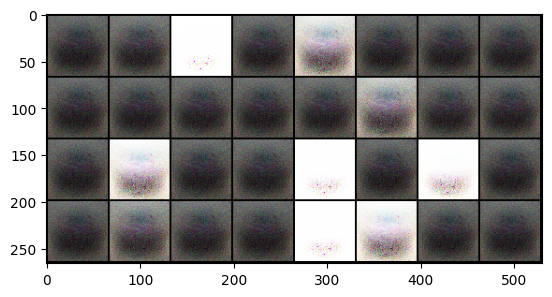

Epoch:1, Batch:0.00, D_loss:0.6389, G_loss:1.6444
Epoch:1, Batch:0.95, D_loss:0.3365, G_loss:1.7058


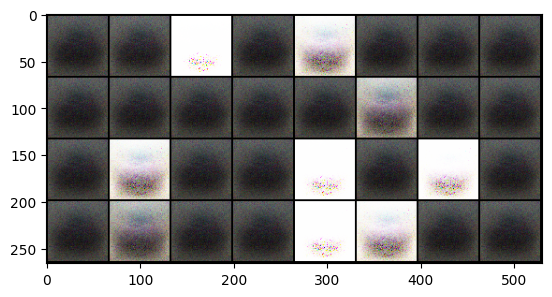

Epoch:2, Batch:0.00, D_loss:0.3357, G_loss:3.6222


KeyboardInterrupt: 

In [35]:
# Define the number of epochs for training
epoches = 10  # Set the number of training epochs

# Create a random tensor for fake images (for visualization after training)
fake_image = torch.randn((32, 100))  # Generate a random noise vector of size 32x100

# Start the training loop for each epoch
for epoch in range(epoches):
    # Loop over each batch of data in the training set
    for i, (data, _) in enumerate(train_dataloader):
        real_data = data  # Get the real data (images) from the batch
        batch_size = real_data.size(0)  # Get the batch size (number of images)

        # Create a random noise vector for generating fake images
        noise = torch.randn((batch_size, 100))  # Generate random noise (32x100)

        # Generate fake data (images) using the generator
        fake_data = Generator_(noise)  # Generate fake images by passing noise through the generator

        # Define labels for real and fake images (1 for real, 0 for fake)
        label_real = torch.full((batch_size,), 1.0)  # Real labels (1 for real images)
        label_fake = torch.full((batch_size,), 0.0)  # Fake labels (0 for fake images)

        # Discriminator outputs for real and fake images
        output_real = Disc(real_data)  # Get discriminator's output for real images
        output_fake = Disc(fake_data.detach())  # Get discriminator's output for fake images (detached to avoid updating generator)

        # Calculate the discriminator loss for real and fake images
        loss_Dreal = criterian(output_real, label_real)  # Loss for real images
        loss_Dfake = criterian(output_fake, label_fake)  # Loss for fake images

        # Total discriminator loss (sum of real and fake losses)
        lossD = loss_Dreal + loss_Dfake

        # Backpropagate and update the discriminator's weights
        optimizer_d.zero_grad()  # Reset gradients
        lossD.backward()  # Compute gradients for discriminator loss
        optimizer_d.step()  # Update discriminator's weights

        # Train the generator to fool the discriminator
        output_fake = Disc(fake_data)  # Get discriminator's output for fake images

        # Calculate generator's loss (how well it fools the discriminator)
        lossG = criterian(output_fake, label_real)  # Generator loss (maximize real labels for fake images)

        # Backpropagate and update the generator's weights
        optimizer_g.zero_grad()  # Reset gradients
        lossG.backward()  # Compute gradients for generator loss
        optimizer_g.step()  # Update generator's weights

        # Print the loss every 100 batches to monitor progress
        if i % 100 == 0:
            print(f"Epoch:{epoch}, Batch:{i/len(train_dataloader):.2f}, D_loss:{lossD.item():.4f}, G_loss:{lossG.item():.4f}")

    # After training each epoch, generate fake images for visualization
    with torch.no_grad():
        fake_images = Generator_(fake_image).detach()  # Generate fake images from random noise without tracking gradients

    # Create a grid of generated fake images and display it using Matplotlib
    img_grid = torchvision.utils.make_grid(fake_images)  # Create a grid from the generated images
    np_img = img_grid.numpy()  # Convert the image grid to a NumPy array
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Display the image grid (transposing the channels for proper display)
    plt.show()  # Show the generated images





## Save our result

In [34]:
# Importing datetime to get the current date and time
from datetime import datetime

# Get the current date and time, formatted as "YYYY-MM-DD HH:MM:SS"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Get current time and format it

# Print the current date and time
print("Current Date and Time:", current_datetime)  # Display the current date and time in the console

# Save the Generator model's state_dict (weights) to a file with the current timestamp in its filename
torch.save(Generator_.state_dict(), f"/content/generator_weight{current_datetime}")  # Save generator weights with timestamp

# Save the Discriminator model's state_dict (weights) to a file with the current timestamp in its filename
torch.save(Disc.state_dict(), f"/content/Dics_weight{current_datetime}")  # Save discriminator weights with timestamp

Current Date and Time: 2024-12-18 06:22:34


## Results and Discussion

This study aimed to generate realistic images of cars using a Generative Adversarial Network (GAN). The results of the training process are presented in above, which shows a grid of 16 generated images at Epoch 7, Batch 8.


The discriminator and generator losses at this stage were 0.7895 and 0.5788, respectively. While these values suggest some progress in the training, the generated images exhibit several limitations. The images appear blurry and lack clear definition, indicating that the generator has not yet learned to capture the intricate details and features of cars, such as wheels, windows, and body shapes.

Several factors could contribute to these results:

Insufficient Training: The model might require more training epochs to learn the complex patterns and features of cars.
Hyperparameter Tuning: The current hyperparameter settings (learning rate, batch size, etc.) might not be optimal for the given dataset and model architecture.
Architectural Limitations: The current GAN architecture might not be suitable for generating high-quality car images.
Data Quality: The quality and diversity of the training data can significantly impact the model's performance.
To address these limitations and improve the model's performance, the following strategies can be explored:

Increase Training Time: Continue training the model for a larger number of epochs.
Fine-tune Hyperparameters: Conduct a hyperparameter search to identify the optimal values for the learning rate, batch size, and other relevant parameters.
Explore Different Architectures: Experiment with different GAN architectures, such as DCGANs or StyleGANs, which are known for generating high-quality images.
Enhance Data Quality: If possible, acquire a larger dataset with higher-resolution and more diverse car images.
Conclusion

The preliminary results of this study demonstrate the potential of GANs for generating car images. However, the current model exhibits limitations in generating realistic and detailed images. Further research is needed to address these limitations and improve the model's performance.